In [9]:
from sklearn.experimental import enable_halving_search_cv # noqa
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score, HalvingGridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.svm import SVC
from sklearn.feature_selection import f_classif, SelectPercentile
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import seaborn as sns

In [10]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [11]:
X = train.loc[:, train.columns!='Activity']
y = train['Activity']

Check for class imbalance

d:\Users\mOh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Activity', ylabel='count'>

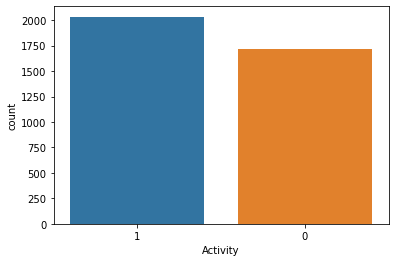

In [32]:
sns.countplot(y.astype(str))

There is no class imbalance, which is a sign of a healthy dataset. Let's now check the profile of certain features to make sure they are normalized and scaled

In [12]:
X.describe()

D1           D2           D3           D4           D5  \
count  3751.000000  3751.000000  3751.000000  3751.000000  3751.000000   
mean      0.076948     0.592436     0.068142     0.038990     0.212112   
std       0.079989     0.105860     0.078414     0.115885     0.102592   
min       0.000000     0.282128     0.000000     0.000000     0.002630   
25%       0.033300     0.517811     0.000000     0.000000     0.138118   
50%       0.066700     0.585989     0.050000     0.000000     0.190926   
75%       0.100000     0.668395     0.100000     0.000000     0.261726   
max       1.000000     0.964381     0.950000     1.000000     1.000000   

                D6           D7           D8           D9          D10  ...  \
count  3751.000000  3751.000000  3751.000000  3751.000000  3751.000000  ...   
mean      0.686653     0.274713     0.455133     0.749517     0.270411  ...   
std       0.078702     0.090017     0.162731     0.071702     0.096128  ...   
min       0.137873     0.006130     0.000000     0.275590     0.003040  ...   
25%       0.625627     0.207374     0.378062     0.707339     0.194357  ...   
50%       0.674037     0.277845     0.499942     0.738961     0.284316  ...   
75%       0.740663     0.335816     0.569962     0.788177     0.344626  ...   
max       0.994735     0.790831     0.989870     1.000000     1.000000  ...   

             D1767        D1768        D1769        D1770        D1771  \
count  3751.000000  3751.000000  3751.000000  3751.000000  3751.000000   
mean      0.026926     0.014663     0.013863     0.021861     0.015196   
std       0.161889     0.120215     0.116938     0.146249     0.122348   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

             D1772        D1773        D1774        D1775        D1776  
count  3751.000000  3751.000000  3751.000000  3751.000000  3751.000000  
mean      0.016796     0.012263     0.011730     0.020261     0.011197  
std       0.128522     0.110074     0.107683     0.140911     0.105236  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 1776 columns]

The mean is not centered around 0 (not scaled and standardized), however we can see that min and max are within the [0,1] interval so the data is indeed close to being normalized

### Standardization

In [13]:
standardScaler = StandardScaler()
X = standardScaler.fit_transform(X)

We will add normalization to ensure that certain features are indeed normalized, given the large number of features and the inability to check them individually

In [8]:
pd.DataFrame(X).describe()

0             1             2             3             4     \
count  3.751000e+03  3.751000e+03  3.751000e+03  3.751000e+03  3.751000e+03   
mean   6.730598e-17 -1.257325e-16  1.107559e-16  1.045699e-16  1.148996e-16   
std    1.000133e+00  1.000133e+00  1.000133e+00  1.000133e+00  1.000133e+00   
min   -1.145873e+00 -1.958024e+00 -9.333339e-01 -3.269497e-01 -1.523580e+00   
25%   -6.293425e-01 -7.424576e-01 -9.333339e-01 -3.269497e-01 -7.341264e-01   
50%   -1.503861e-01 -1.432403e-01 -1.879610e-01 -3.269497e-01 -3.425741e-01   
75%    4.575297e-01  6.023405e-01  5.708329e-01 -3.269497e-01  4.968193e-01   
max    7.398854e+00  3.793352e+00  5.675284e+00  1.272934e+01  5.035385e+00   

               5             6             7             8             9     \
count  3.751000e+03  3.751000e+03  3.751000e+03  3.751000e+03  3.751000e+03   
mean  -9.992303e-17  1.556118e-17  3.661279e-17 -5.559699e-16 -1.678506e-16   
std    1.000133e+00  1.000133e+00  1.000133e+00  1.000133e+00  1.000133e+00   
min   -2.430414e+00 -2.005581e+00 -2.281256e+00 -1.975785e+00 -1.956000e+00   
25%   -7.253916e-01 -7.444254e-01 -6.704992e-01 -7.404072e-01 -7.399990e-01   
50%   -1.928047e-01 -1.468197e-01 -5.284083e-02 -1.737801e-01 -1.068965e-01   
75%    5.462290e-01  5.958852e-01  6.039901e-01  5.866128e-01  6.181875e-01   
max    4.174317e+00  7.921085e+00  4.774026e+00  4.372330e+00  1.040636e+01   

       ...          1766          1767          1768          1769  \
count  ...  3.751000e+03  3.751000e+03  3.751000e+03  3.751000e+03   
mean   ... -6.644319e-16 -1.643062e-16  1.045477e-16  1.009442e-15   
std    ...  1.000133e+00  1.000133e+00  1.000133e+00  1.000133e+00   
min    ... -1.658824e-01 -1.216930e-01 -1.183021e-01 -1.491999e-01   
25%    ... -1.658824e-01 -1.216930e-01 -1.183021e-01 -1.491999e-01   
50%    ... -1.658824e-01 -1.216930e-01 -1.183021e-01 -1.491999e-01   
75%    ... -1.658824e-01 -1.216930e-01 -1.183021e-01 -1.491999e-01   
max    ...  6.766409e+00  9.079764e+00  9.500085e+00  7.335677e+00   

               1770          1771          1772          1773          1774  \
count  3.751000e+03  3.751000e+03  3.751000e+03  3.751000e+03  3.751000e+03   
mean   7.120552e-17  2.400846e-16  1.821538e-16  7.941898e-17  3.362339e-16   
std    1.000133e+00  1.000133e+00  1.000133e+00  1.000133e+00  1.000133e+00   
min   -1.238082e-01 -1.303525e-01 -1.110430e-01 -1.086579e-01 -1.434033e-01   
25%   -1.238082e-01 -1.303525e-01 -1.110430e-01 -1.086579e-01 -1.434033e-01   
50%   -1.238082e-01 -1.303525e-01 -1.110430e-01 -1.086579e-01 -1.434033e-01   
75%   -1.238082e-01 -1.303525e-01 -1.110430e-01 -1.086579e-01 -1.434033e-01   
max    9.000891e+00  8.534378e+00  1.004992e+01  1.005304e+01  7.842505e+00   

               1775  
count  3.751000e+03  
mean   8.702420e-16  
std    1.000133e+00  
min   -1.061369e-01  
25%   -1.061369e-01  
50%   -1.061369e-01  
75%   -1.061369e-01  
max    1.029071e+01  

[8 rows x 1776 columns]

### Normalization

In [14]:
normalizer = Normalizer()
X = normalizer.fit_transform(X)

In [6]:
pd.DataFrame(X).describe()

0            1            2            3            4     \
count  3751.000000  3751.000000  3751.000000  3751.000000  3751.000000   
mean      0.006534     0.056661     0.005808     0.003235     0.021859   
std       0.005703     0.016196     0.006224     0.009897     0.014244   
min       0.000000     0.024953     0.000000     0.000000     0.000160   
25%       0.002945     0.044638     0.000000     0.000000     0.011403   
50%       0.005676     0.054341     0.004638     0.000000     0.016980   
75%       0.009143     0.066416     0.009360     0.000000     0.028935   
max       0.048722     0.118091     0.041124     0.129204     0.093573   

              5            6            7            8            9     ...  \
count  3751.000000  3751.000000  3751.000000  3751.000000  3751.000000  ...   
mean      0.065887     0.027376     0.042838     0.072089     0.026863  ...   
std       0.017539     0.013393     0.018781     0.019148     0.013636  ...   
min       0.023265     0.000519     0.000000     0.034262     0.000195  ...   
25%       0.053166     0.017407     0.030247     0.057914     0.016774  ...   
50%       0.062506     0.025410     0.041846     0.068762     0.025405  ...   
75%       0.075466     0.035355     0.054180     0.083320     0.035291  ...   
max       0.139092     0.133447     0.132487     0.155797     0.168742  ...   

              1766         1767         1768         1769         1770  \
count  3751.000000  3751.000000  3751.000000  3751.000000  3751.000000   
mean      0.001433     0.000788     0.000733     0.001190     0.000807   
std       0.008641     0.006476     0.006196     0.007974     0.006519   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       0.059896     0.059585     0.059585     0.059677     0.059476   

              1771         1772         1773         1774         1775  
count  3751.000000  3751.000000  3751.000000  3751.000000  3751.000000  
mean      0.000898     0.000650     0.000636     0.001070     0.000609  
std       0.006888     0.005853     0.005854     0.007462     0.005741  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max       0.059677     0.059463     0.059476     0.059585     0.059677  

[8 rows x 1776 columns]

Given the large number of features, we need to do some feature selection. We will start with PCA and tune it with the SVM model combination

# PCA-SVM

### PCA

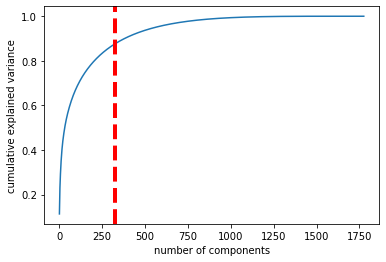

In [6]:
pca_test = PCA(n_components=1776)
pca_test.fit(X)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=324, ymin=0, ymax=1)
plt.show()
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr

We can see that 95% of inertia is at 350 features

In [15]:
pca = PCA(n_components=350)
X_pca = pca.fit_transform(X)
pca.n_components_

350

### Grid Search for SVM

We will apply a grid search to find the best parameters for SVM

In [16]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear']}
 
grid = GridSearchCV(SVC(probability=True), param_grid, refit = True, verbose = 3, scoring='roc_auc')
 
# fitting the model for grid search
grid.fit(X_pca, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.805 total time=  12.7s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.827 total time=  11.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.796 total time=  11.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.816 total time=  10.5s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.812 total time=   9.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.815 total time=   7.8s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.831 total time=   6.7s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.802 total time=   6.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.827 total time=   5.9s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.821 total time=   6.6s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.745 total time=   9.8s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

Function to plot grid search results

In [13]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    # means_train = results['mean_train_score']
    # stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        # y_2 = np.array(means_train[best_index])
        # e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        # ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

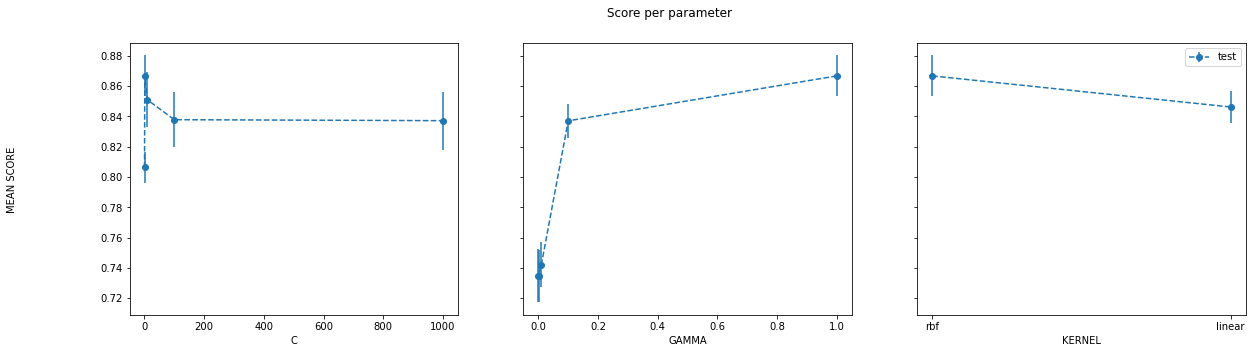

In [14]:
plot_search_results(grid)

In [12]:
grid.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

As seen in the graphs, the best AUC score is earned when C is at 1, Gamma is at 1 and the kernel is rbf

In [ ]:
grid.best_score_

This is a good score and we will proceed to submitting the results to kaggle.

### Submission 1

In [15]:
pca_test = standardScaler.transform(test)
pca_test = normalizer.transform(pca_test)
pca_test = pca.transform(pca_test)
predicted_prob = grid.predict_proba(pca_test)
Probability = predicted_prob[:,1]
MoleculeId = np.array(range(1,len(pca_test)+1))
submission = pd.DataFrame()
submission["MoleculeId"] = MoleculeId
submission['PredictedProbability'] = Probability
submission.to_csv('submission1.csv',index=None)
print(submission)

      MoleculeId  PredictedProbability
0              1              0.867585
1              2              0.902458
2              3              0.680494
3              4              0.963736
4              5              0.035101
...          ...                   ...
2496        2497              0.422293
2497        2498              0.086365
2498        2499              0.968186
2499        2500              0.891316
2500        2501              0.265749

[2501 rows x 2 columns]


This model earns a `0.45071` on public and `0.40221` in private in kaggle 

Let's try another feature selection algorithm to check if we can improve the scores

# ANOVA-SVM

Let's try to use ANOVA to select the best number features, we chose ANOVA because output is categorical and feautures are numerical

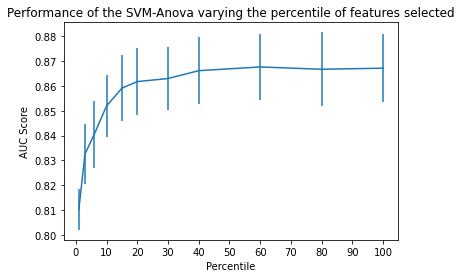

In [16]:
clf = Pipeline(
    [
        ("anova", SelectPercentile(f_classif)),
        ("svc", SVC()),
    ]
)

score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(clf, X, y, scoring="roc_auc")
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title("Performance of the SVM-Anova varying the percentile of features selected")
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel("Percentile")
plt.ylabel("AUC Score")
plt.axis("tight")
plt.show()

The best score is around 40%, after which we start seeing diminishing returns

### ANOVA

We will use the 40% mark as shown above

In [17]:
anova = SelectPercentile(f_classif, percentile=40)
X_anova = anova.fit_transform(X, y)

### Grid Search for SVM

In [18]:
param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(probability=True), param_grid, refit = True, verbose = 3, scoring='roc_auc')
 
# fitting the model for grid search
grid.fit(X_anova, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.811 total time=  21.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.830 total time=  18.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.800 total time=  17.7s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.825 total time=  19.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.815 total time=  18.2s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.743 total time=  23.5s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.764 total time=  21.3s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.717 total time=  21.8s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.742 total time=  20.6s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.736 total time=  20.2s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.741 total time=  20.6s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;,

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf']},
             scoring='roc_auc', verbose=3)

In [19]:
grid.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [ ]:
grid.best_score_

The scores are good enough and we will check for improvement on the test set on kaggle.

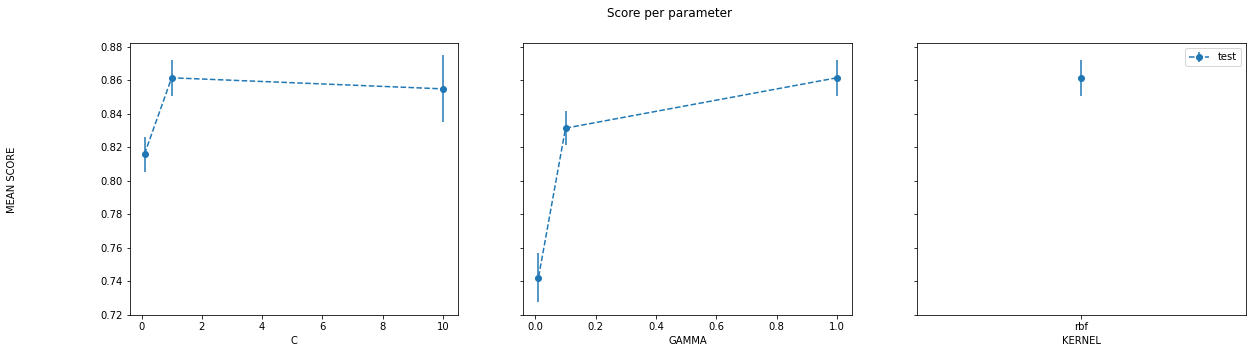

In [20]:
plot_search_results(grid)

Given the last grid search time to tune, we eliminated the linear kernel and proceeded to tune the gamma and C factors, to which we got the same score as the previous model.

### Submission 2

In [21]:
anova_test = standardScaler.transform(test)
anova_test = normalizer.transform(anova_test)
anova_test = anova.transform(anova_test)
predicted_prob = grid.predict_proba(anova_test)
Probability = predicted_prob[:,1]
MoleculeId = np.array(range(1,len(anova_test)+1))
submission = pd.DataFrame()
submission["MoleculeId"] = MoleculeId
submission['PredictedProbability'] = Probability
submission.to_csv('submission2.csv',index=None)
print(submission)

      MoleculeId  PredictedProbability
0              1              0.835337
1              2              0.898091
2              3              0.817877
3              4              0.966169
4              5              0.077948
...          ...                   ...
2496        2497              0.485020
2497        2498              0.080842
2498        2499              0.959064
2499        2500              0.871000
2500        2501              0.186980

[2501 rows x 2 columns]


This model earns a `0.4637` on public and `0.49117` in private in kaggle which is quite lower than the previous score. Let's set the basis for some tree based algorithms.

# Decision Tree Classifier

We will start out with a simple decision tree classifier with the PCA features

In [31]:
from scipy.stats import randint

param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': randint(100, 1000),
              'min_samples_split': randint(1,10),
              'min_samples_leaf': randint(1,10)}

search = HalvingRandomSearchCV(DecisionTreeClassifier(), param_grid,
                               resource='n_estimators',
                               max_resources=10,
                               random_state=0,
                               refit = True, verbose = 3, scoring='roc_auc')
 

grid.fit(X_pca, y)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV 1/5] END criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=2;, score=0.666 total time=   2.4s
[CV 2/5] END criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=2;, score=0.672 total time=   2.2s
[CV 3/5] END criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=2;, score=0.648 total time=   2.2s
[CV 4/5] E

d:\Users\mOh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
360 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Users\mOh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Users\mOh\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "d:\Users\mOh\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 250, in fit
    raise ValueError(
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [100, 200, 500, 1000],
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(1, 10)},
             scoring='roc_auc', verbose=3)

In [32]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 100,
 'min_samples_leaf': 8,
 'min_samples_split': 8}

In [33]:
grid.best_score_

0.7112006481833864

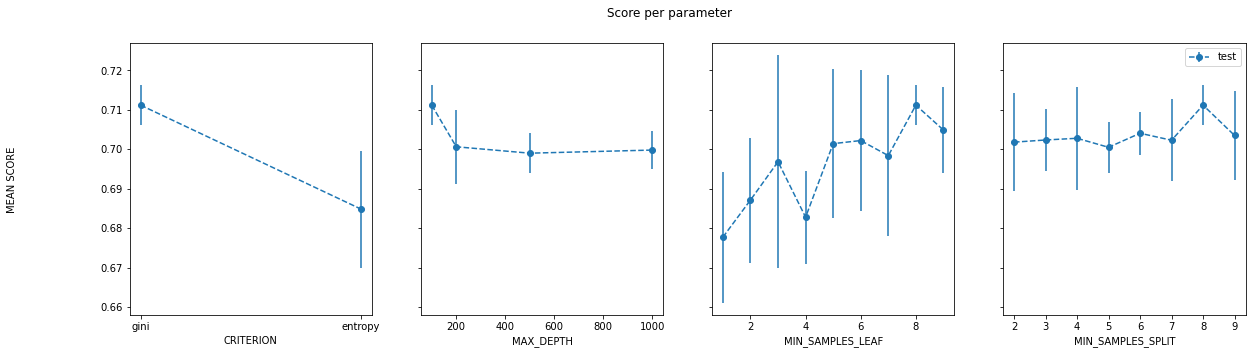

In [34]:
plot_search_results(grid)

This score is reasonably lower than the SVM, but it sets the basis for stronger ensemble learning models.

# Adaboost Classifier

We will start with the adaptive boost classifier to add error correction to the trees. Given the large computation time to complete the grid search, we will use a different more efficient search namely `HalvingRandomSearch`

In [ ]:
param_grid = {'n_estimators' : [50, 100, 200, 500, 1000], 
              'base_estimator__max_depth' : randint(1,3)
             }
 
grid = HalvingRandomSearchCV(AdaBoostClassifier(DecisionTreeClassifier()), param_grid, refit = True, verbose = 3, scoring='roc_auc')

grid.fit(X_pca, y)

In [44]:
grid.best_params_

{'base_estimator__max_depth': 2, 'n_estimators': 1000}

In [45]:
grid.best_score_

0.7706527652298194

This score is still lower than the SVM score, we will not submit and try another algoritm

In [12]:
def plot_rnd_search_results(rsh):
    results = pd.DataFrame(rsh.cv_results_)
    results["params_str"] = results.params.apply(str)
    results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
    mean_scores = results.pivot(
        index="iter", columns="params_str", values="mean_test_score"
    )
    ax = mean_scores.plot(legend=False, alpha=0.6)

    labels = [
        f"iter={i}\nn_samples={rsh.n_resources_[i]}\nn_candidates={rsh.n_candidates_[i]}"
        for i in range(rsh.n_iterations_)
    ]

    ax.set_xticks(range(rsh.n_iterations_))
    ax.set_xticklabels(labels, rotation=45, multialignment="left")
    ax.set_title("Scores of candidates over iterations")
    ax.set_ylabel("mean test score", fontsize=15)
    ax.set_xlabel("iterations", fontsize=15)
    plt.tight_layout()
    plt.show()


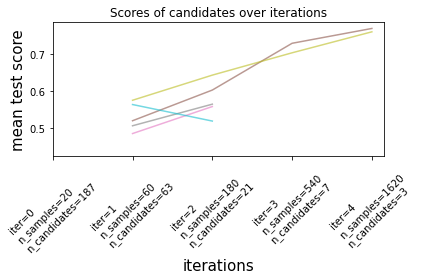

In [75]:
plot_rnd_search_results(grid)

The scores are still low, however the grid search uses an iterative approach to eliminate the low scoring parameters with little samples and progressively adds samples to stronger candidates. We started with 20 samples and 187 candidates and ended up with 3 candidates over 1620 samples

# XGBoost Classifier

In [15]:
from xgboost import XGBClassifier

param_grid = {'colsample_bytree' : [0.5, 1.0, 1.5, 2],
'gamma' : [ 1, 1.5, 2, 5],
'learning_rate' : [0.01, 0.1, 1],
'min_child_weight' : [0.01 ,0.5, 1],
'scale_pos_weight' : [1.5, 2, 2.5],
'subsample' : [1.0, 1.1, 2],
'n_estimators' : [150, 200, 500],
'max_depth' : [5, 10, 15, 20]
}

classifier = XGBClassifier(tree_method='gpu_hist', random_state=1, verbosity=1, use_label_encoder =False)

grid = HalvingGridSearchCV(classifier, param_grid, refit = True, verbose = 3)

grid.fit(X_pca, y)

TypeError: Parameter value is not iterable or distribution (key='colsample_bytree', value=0.5)

In [10]:
grid.best_params_

{'subsample': 1.0,
 'scale_pos_weight': 2,
 'n_estimators': 150,
 'min_child_weight': 1,
 'max_depth': 10,
 'learning_rate': 0.01,
 'gamma': 1.5,
 'colsample_bytree': 1.0}

In [11]:
grid.best_score_

0.6850342086152199

In [7]:
plot_rnd_search_results(grid)

NameError: name 'plot_rnd_search_results' is not defined

In [25]:
from sklearn.model_selection import cross_val_score

cross_val_score(grid, X_pca, y, cv=5, scoring='roc_auc').mean()

0.834528467278496

In [19]:
from xgboost import XGBClassifier

param_grid = {'colsample_bytree' : [0.3, 0.5, 1.0],
'gamma' : [0.1, 1, 1.5],
'learning_rate' : [0.001, 0.01],
'min_child_weight' : [1, 5, 10],
'scale_pos_weight' : [1, 2, 4],
'subsample' : [0.8, 0.9, 1.0],
'n_estimators' : [50, 100, 150],
'max_depth' : [5, 10]}

classifier = XGBClassifier(random_state=1, verbosity=1, use_label_encoder =False)

grid = HalvingGridSearchCV(classifier, param_grid, refit = True, verbose = 3)

grid.fit(X, y)

n_iterations: 5
n_required_iterations: 8
n_possible_iterations: 5
min_resources_: 20
max_resources_: 3751
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 2916
n_resources: 20
Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.001, max_depth=5, min_child_weight=1, n_estimators=50, scale_pos_weight=1, subsample=0.8;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.001, max_depth=5, min_child_weight=1, n_estimators=50, scale_pos_weight=1, subsample=0.8;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.001, max_depth=5, min_child_weight=1, n_estimators=50, scale_pos_weight=1, subsample=0.8;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.001, max_depth=5, min_child_weight=1, n_estimators=50, scale

HalvingGridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_...
                                            n_estimators=100, n_jobs=None,
                           

In [20]:
grid.best_params_

{'colsample_bytree': 1.0,
 'gamma': 0.1,
 'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 150,
 'scale_pos_weight': 1,
 'subsample': 0.8}

In [21]:
grid.best_score_

0.7698065971027788

In [22]:
X_test = standardScaler.transform(test)
X_test = normalizer.transform(X_test)
X_test = pca.transform(X_test)
predicted_prob = grid.predict_proba(test)
Probability = predicted_prob[:,1]
MoleculeId = np.array(range(1,len(test)+1))
submission = pd.DataFrame()
submission["MoleculeId"] = MoleculeId
submission['PredictedProbability'] = Probability
submission.to_csv('submission3.csv',index=None)
print(submission)

      MoleculeId  PredictedProbability
0              1              0.397520
1              2              0.451637
2              3              0.522310
3              4              0.533781
4              5              0.440542
...          ...                   ...
2496        2497              0.404874
2497        2498              0.430481
2498        2499              0.461483
2499        2500              0.448641
2500        2501              0.376905

[2501 rows x 2 columns]
